# Introduction
A/B Testing main goal is to test the changes in a product or feature with the aim of understanding if the changes had an impact on user behavior pattern. The data is from an ecommerce that changed their webpage to improve the number of paying customers. They are conducting an A/B test to check the impact of the new page. There are two main groups namely Control and Experiment Groups. The experiment group is presented with the new page while the control group is presented with the old web page. Data was collected during the experiment to facilitate hypothesis testing to check if the difference is significant. 

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats 
import statsmodels.stats.api as sms 
import matplotlib.pyplot as plt 
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Key Steps:
* Establishing the baseline test parameters that might include baseline conversion rate, significance level and confidence level.
* Hypothesis creation.
* Assumption Check
* Hypothesis Testing
* Conclusion

## Creating Hypothesis
* **Null Hypothesis**: The conversion rate for the two pages is the same.
* **Alternative Hypothesis**: The conversion rate for the two pages is not the same.

* The confidence level will be 95% i.e. 
         threshold = (1 - 0.95) = 0.05
* The null hypothesis is rejected if the  p-value is below the threshold and the new page design is accepted. 

### Dataset
* **User_id:** unique user number
* **timestamp:** Time
* **group:**  Treatment and Control Group
* **landing_page:** old page or new page
* **converted:** sign up status after viewing the page

### Setting Base Parameters
* **Effect Size:** A measure used to evaluate the strength of a statisticcal claim. It is applied in the statistical hypothesis to determine the power of a statistical test. The standard deviation of the effect size shows the level of uncertainty in the measurement. It has a direct relationship with the difference that is noted between the control and experiment groups. 
* In this analysis, the effect size is set at 2.5% 
* The power of the test is typically set at 0.8.
* The analysis will use a baseline conversion rate of 13% which makes the expected conversion to be 15.5% because of the effect size is 2.5%.

In the next section, the required sample size is calculated.

In [2]:
# Determining effect size based on expected rates
effect_size = sms.proportion_effectsize(0.13,0.15)

# Required sample size
sample_size = sms.NormalIndPower().solve_power(effect_size, alpha=0.05, power=0.8, ratio=1)

sample_size = int(np.ceil(sample_size))
print(f"The minimum required sample size from each group: {sample_size} observations.")

The minimum required sample size from each group: 4720 observations.


* This means that we need at least 4,720 observations of each group are needed from the experiment to achieve the required minimum sample size.  
* The base parameter settings for the experiment imply that with the power of 0.8, if there is a difference between the conversion rates (2.5%) there is an 80% chance to detect it as statistically significant.

## Exploratory Data Analysis

In [3]:
df = pd.read_csv('/kaggle/input/ecommerce-ab-testing-2022-dataset1/ecommerce_ab_testing_2022_dataset1/ab_data.csv')
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1
5,936923,20:49.1,control,old_page,0
6,679687,26:46.9,treatment,new_page,1
7,719014,48:29.5,control,old_page,0
8,817355,58:09.0,treatment,new_page,1
9,839785,11:06.6,treatment,new_page,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


Looking at the cross tabulated frequency of the control and experiment groups.

In [5]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145313,1965


From the output, some users of the control group are incorrectly exposed to the new page and some users in the treatment group are incorrectly exposed to the old page. 

The factor to consider is whether there are uses who have been counted twice during the experiment. 

In [6]:
# Checking if some users appear multiple times
user_sessions = df['user_id'].value_counts()

multiple_times_user = user_sessions[user_sessions > 1].count()

print(f"There are {multiple_times_user} users that appear more than once in the dataset.")

There are 3895 users that appear more than once in the dataset.


Sampling one user more than once will affect the outcome of the experiment. Therefore, the next step is the elimination of the users who have been sampled more than once. 

In [7]:
# Get indices for the users to remove
eliminate_users = user_sessions[user_sessions > 1].index

df = df[~df['user_id'].isin(eliminate_users)]

print(f"The updated data has {df.shape[0]} observations, after the removal of users who \
appear multiple times.")

The updated data has 286690 observations, after the removal of users who appear multiple times.


The next step is to sample both the control and experiment groups based on the required sample size that was calculated using the set base parameters.

In [8]:
# Set the treatment group sample
treatment_sample = df[df['group']=='treatment'].sample(n=sample_size, random_state=5)

# Set the Control group sample
control_sample = df[df['group'] == 'control'].sample(n=sample_size, random_state=5)


# Combine the two samples into one dataframe
ab_test = pd.concat([control_sample, treatment_sample], axis=0)

# Reset index
ab_test.reset_index(drop=True, inplace=True)

# print value counts for each group
print(ab_test['group'].value_counts())

# Check the info for the abtest dataframe
ab_test.info()

control      4720
treatment    4720
Name: group, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In the next section, we look at the conversion rates for both groups and computer standard deviation and standard errors for both groups.

In [9]:
# Group by control groups based on conversion
rate_conversion = ab_test.groupby('group')['converted']

# Get standard deviation of the proportion
std_p = lambda x: np.std(x, ddof = 0)

# Standard Error
std_e = lambda x: stats.sem(x, ddof=0)

# Aggregate values 
rate_conversion = rate_conversion.agg([np.mean, std_p, std_e])

# Set column names 
rate_conversion.columns = ['conversion_rate', 'std_deviation', 'std_error']

# show output
rate_conversion.style.format('{:.4f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.1222,0.3276,0.0048
treatment,0.1231,0.3285,0.0048


* The results show that the conversion rate for the control group is 12.22% and the one for the treatment group is 12.31%. 
* Plotting the results can provide a clear picture.

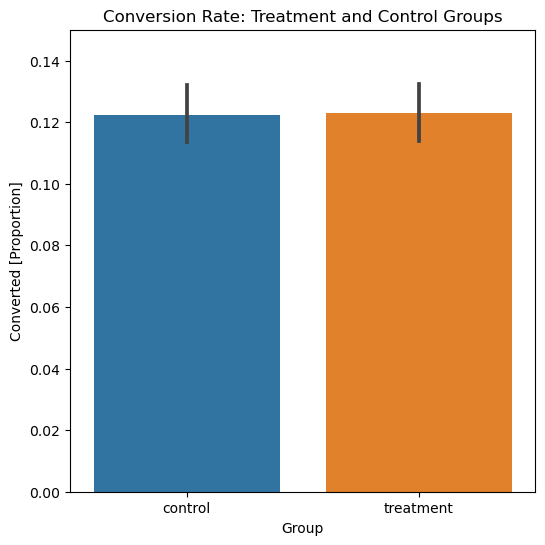

In [10]:
# Plot results
plt.figure(figsize=(6,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'])

plt.ylim(0, 0.15)
plt.title("Conversion Rate: Treatment and Control Groups")
plt.xlabel("Group")
plt.ylabel("Converted [Proportion]")
plt.show()

* The conversion rate for the treatment group is slighly than that of the control group. Checking if the small difference is statistically significant can inform the decision to reject or accept the null hypothesis. 

In [11]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint 

# Users converted in the control group
converted_control = ab_test[ab_test['group']=='control']['converted']

# Users converted in treatment group
converted_treatment = ab_test[ab_test['group']=='treatment']['converted']

# number of users in control and treatment
n_control = converted_control.count()

n_treatment = converted_treatment.count()

# Successfully converted
positive_outcome = [converted_control.sum(), converted_treatment.sum()]

# observations
nobs = [n_control, n_treatment]

# calculate zstat and proportions using statsmodel
z_stat, pval = proportions_ztest(positive_outcome, nobs=nobs)

(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(positive_outcome, nobs=nobs, alpha=0.05)


print(f"z statistic: {z_stat:.2f}")
print(f"p value: {pval:.3f}")
print(f"95% Confidence Level for Control Group: [{lower_con:.3f}, {upper_con:.3f}]")
print(f"95% Confidence Level for Treatment Group: [{lower_treat:.3f}, {upper_treat:.3f}]")

z statistic: -0.13
p value: 0.900
95% Confidence Level for Control Group: [0.113, 0.132]
95% Confidence Level for Treatment Group: [0.114, 0.132]


## Conclusion

* The p-value is 0.9, which is higher than 0.05. Therefore, the probability of observing extreme results is small. The null hypothesis cannot be rejected.
* In conclusion, the new page does not perform significantly better than the new page for the ecommerce site. The new design does not exceed the expectations needed to have a significantly better conversion rate compared to the old page.